In [2]:
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import skimage.io as io
import skimage.exposure as exposure
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray

In [3]:
labels = []
with open('data/menu_match_dataset/labels.txt') as f:
    content = f.read()
for l in content.splitlines():
    split_line = l.split(';')
    name = split_line[0]
    lab = split_line[1:]
    lab.remove('')
    d = {'image_name': name}
    for i in range(len(lab)):
        d["label_" + str(i + 1)] = lab[i]
    d["num_labels"] = len(lab)
    labels.append(d)

In [4]:
df = json_normalize(labels)

In [5]:
len(df)

646

In [6]:
df.head()

,image_name,label_1,label_2,label_3,label_4,num_labels
0,img1.jpg,pineapple_pizza,NaN,NaN,NaN,1
1,img2.jpg,ginger_chicken,jasmine_rice,mapo_tofu,NaN,3
2,img3.jpg,brown_rice,panang_curry_chicken,vegetable_spring_roll,NaN,3
3,img4.jpg,jasmine_rice,orange_chicken,NaN,NaN,2
4,img5.jpg,jasmine_rice,orange_chicken,panang_curry_chicken,NaN,3


In [7]:
# Maximum number of labels
print("Max number of labels: {}".format(max(df['num_labels'])))

Max number of labels: 4


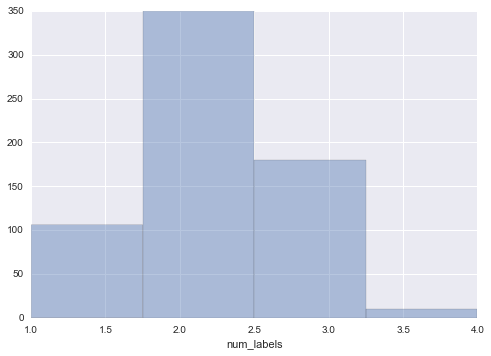

In [8]:
# Histogram of labels
sns.distplot(df['num_labels'], kde=False, bins=4);

In [9]:
df.groupby('label_1').size().sort_values(ascending=False).head(15)

label_1
 brown_rice                  172
 jasmine_rice                130
 cheese_pizza                 43
 bread_sticks                 34
 pineapple_pizza              32
 pepperoni_pizza              31
 cashew_chicken               25
 ciabatta                     24
 chicken_coconut_curry        23
 lobster_bisque_soup          18
 meatlovers_pizza             16
 ginger_chicken               10
 combo_supreme                10
 creamy_tomato_basil_soup      7
 vegetarian_lentils_soup       7
dtype: int64

In [10]:
df.groupby('label_2').size().sort_values(ascending=False).head(15)

label_2
 panang_curry_chicken         114
 orange_chicken                57
 pepperoni_pizza               34
 potato_bread                  32
 jasmine_rice                  31
 whole_wheat_bread             27
 mapo_tofu                     25
 spicy_chicken_with_basil      19
 ginger_chicken                18
 spicy_string_beans            17
 lobster_bisque_soup           16
 cashew_chicken                15
 stirfry_beef                  14
 chicken_alfredo               14
 yellow_curry_with_chicken     12
dtype: int64

In [11]:
df.groupby('label_3').size().sort_values(ascending=False).head(15)

label_3
 spicy_string_beans              41
 panang_curry_chicken            36
 yellow_curry_with_chicken       21
 stirfry_beef                    21
 vegetable_spring_roll           18
 stir-fry_garlic_soba_noodles    16
 spicy_chicken_with_basil         8
 orange_chicken                   8
 sweet_and_sour_vegetables        6
 spinach_red_curry_with_tofu      4
 side_salad                       4
 jasmine_rice                     3
 vegetarian_pizza                 2
 mapo_tofu                        2
dtype: int64

In [12]:
df.groupby('label_4').size().sort_values(ascending=False).head(15)

label_4
 vegetable_spring_roll          7
 yellow_curry_with_chicken      1
 stirfry_beef                   1
 spinach_red_curry_with_tofu    1
dtype: int64

In [13]:
all_labels = df[['image_name','label_1']].rename_axis({"image_name": "image_name", "label_1": "label"}, axis="columns")
all_labels = all_labels.append(df[['image_name','label_2']].rename_axis({"image_name": "image_name", "label_2": "label"}, axis="columns"))
all_labels = all_labels.append(df[['image_name','label_3']].rename_axis({"image_name": "image_name", "label_3": "label"}, axis="columns"))
all_labels = all_labels.append(df[['image_name','label_4']].rename_axis({"image_name": "image_name", "label_4": "label"}, axis="columns"))

In [14]:
print("In total there are {:,} labelled items".format(len(all_labels)))

In total there are 2,584 labelled items


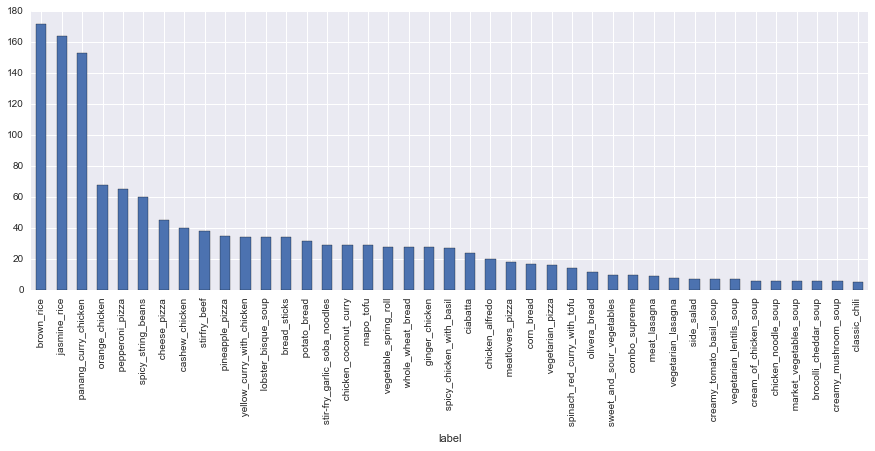

In [19]:
# Look at all labels
all_labels.groupby('label').size().sort_values(ascending=False).plot(kind='bar', figsize=(15,5));

In [20]:
df = df.fillna('')

In [21]:
# Chicken, pizza, rice, soup, bread (including ciabatta, lasagne, salad)
def is_type(t,l):
    """
    Searches for string in list of strings
    t: string to search for (in this case type of food)
    l: list of strings (in this case list of different labels)
    returns: 1 if string is present in at least one memeber of list, otherwise 0
    """
    for i in (range(len(l))):
        if re.search(t, l[i]):
            return 1
    return 0

def is_bread(l):
    """
    Confirms if a set of labels contains bread, which can be represented in different ways
    l: list of labels
    return: 1 if bread present, otherwise 0
    """
    for i in (range(len(l))):
        if re.search(r'bread|ciabatta', l[i]):
            return 1
    return 0

In [22]:
df['pizza'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('pizza',row), axis=1)
df['chicken'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('chicken',row), axis=1)
df['rice'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('rice',row), axis=1)
df['soup'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('soup',row), axis=1)
df['lasagne'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('lasagne',row), axis=1)
df['salad'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_type('salad',row), axis=1)
df['bread'] = df[['label_1', 'label_2', 'label_3', 'label_4']].apply(lambda row: is_bread(row), axis=1)

In [456]:
#Distribution of image sizes
images = []
for i in df['image_name']:
    images.append([i, io.imread('data/menu_match_dataset/foodimages/' + i)])

In [531]:
sizes = []
for im in images:
    sizes.append({'image_name': im[0], 'image_shape': im[1].shape, 'data_type': im[1].dtype})

In [548]:
df = df.merge(pd.DataFrame.from_dict(sizes))

In [549]:
df.head(1)

,image_name,label_1,label_2,label_3,label_4,num_labels,pizza,chicken,rice,soup,lasagne,salad,bread,data_type,image_shape
0,img1.jpg,pineapple_pizza,,,,1,1,0,0,0,0,0,0,uint8,"(1000, 1776, 3)"


In [550]:
df.groupby('image_shape').size().sort_values(ascending=False)

image_shape
(1000, 1776, 3)    145
(1632, 1224, 3)    121
(1500, 2000, 3)    115
(1224, 1632, 3)     67
(1776, 1000, 3)     48
(864, 1536, 3)      31
(1632, 920, 3)      27
(1296, 968, 3)      18
(1536, 864, 3)      12
(920, 1632, 3)      12
(968, 1296, 3)      11
(600, 991, 3)        2
(683, 998, 3)        1
(678, 994, 3)        1
(721, 994, 3)        1
(696, 996, 3)        1
(640, 987, 3)        1
(721, 996, 3)        1
(674, 991, 3)        1
(629, 978, 3)        1
(638, 998, 3)        1
(638, 971, 3)        1
(633, 996, 3)        1
(766, 987, 3)        1
(625, 985, 3)        1
(620, 978, 3)        1
(613, 985, 3)        1
(586, 994, 3)        1
(753, 989, 3)        1
(831, 980, 3)        1
(768, 976, 3)        1
(928, 991, 3)        1
(1186, 996, 3)       1
(1029, 976, 3)       1
(1011, 978, 3)       1
(992, 825, 3)        1
(955, 985, 3)        1
(950, 973, 3)        1
(940, 973, 3)        1
(917, 996, 3)        1
(786, 985, 3)        1
(914, 991, 3)        1
(905, 976, 3)        1

In [551]:
df['X'] = df['image_shape'].apply(lambda x: x[0])
df['Y'] = df['image_shape'].apply(lambda x: x[1])

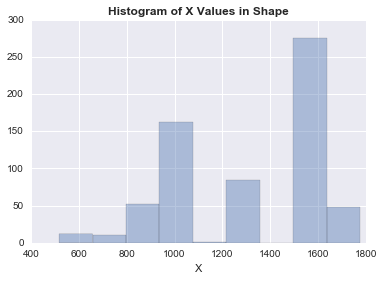

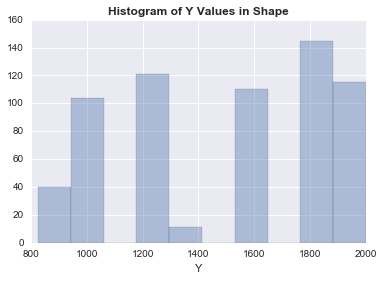

In [552]:
#X Values
ax = sns.distplot(df['X'], kde=False)
ax.set_title("Histogram of X Values in Shape", weight="bold")
plt.show()

#Y Values
ax = sns.distplot(df['Y'], kde=False)
ax.set_title("Histogram of Y Values in Shape", weight="bold")
plt.show()

In [553]:
df.groupby('data_type').size()

data_type
uint8    646
dtype: int64

In [554]:
single_class = df[df['num_labels'] == 1]

In [556]:
print("There are {} images with just one label".format(len(single_class)))

There are 106 images with just one label


In [558]:
single_class.groupby('label_1').size().sort_values(ascending=False)

label_1
 pepperoni_pizza       29
 cheese_pizza          26
 pineapple_pizza       16
 meatlovers_pizza      11
 chicken_alfredo        6
 vegetarian_pizza       5
 combo_supreme          5
 vegetarian_lasagna     3
 whole_wheat_bread      1
 stirfry_beef           1
 side_salad             1
 meat_lasagna           1
 brown_rice             1
dtype: int64

In [665]:
df.to_csv('data/menu_match_dataset/basic_info.csv', index=False)